In [68]:
from rtlsdr import RtlSdr  
import numpy as np  
import scipy.signal as signal
import struct

from matplotlib import pyplot as plt
%matplotlib inline

sdr = RtlSdr()

In [69]:
F_station = int(93.9e6)   # Local Chicago radio station
F_offset = 250000         # Offset to capture at; we capture at an offset
                          #  to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(1140000)         # Sample rate  
N = int(8192000)          # Samples to capture  

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).astype("complex64")

In [70]:
# write the raw input data to file
# save the input "x" vector file
raw_data_file = open("../vectors/ota_fm_radio_data.bin", 'wb')

for idx in range(len(x1)):
    
    # pack as little endian format using float
    raw_data_file.write(struct.pack('<2f', x1[idx].real, x1[idx].imag))
    
raw_data_file.close()

Now that we've acquired our samples, we can plot the spectogram:

(-570000.0, 570000.0)

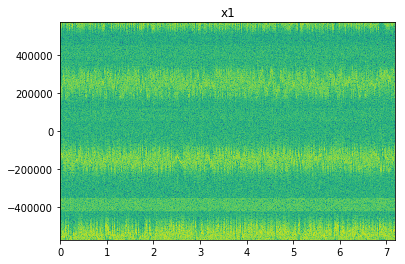

In [71]:
plt.specgram(x1, NFFT=2048, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2)

Looking at the spectogram, we can see that as expected, our FM radio signal is located at an offset from the center. To shift it, in the Python window, run

In [72]:
rollover_idx_float = Fs / abs(F_offset)
print("Calculated float rollover index %.16f" % (rollover_idx_float))

while rollover_idx_float < 1e5:
    rollover_idx_float = rollover_idx_float * 10.0

print("Adjusted float rollover index to %.16f" % (rollover_idx_float))
    
rollover_idx = np.round(rollover_idx_float)
print("Computed max integer rollover index %u" % (rollover_idx))

t = np.arange(0, len(x1), dtype=np.float32)
for ii in range(len(x1)):
    t[ii] = ii % rollover_idx
    
angular_freq = 2.0 * np.pi * (-F_offset/INPUT_SAMPLE_RATE)
print("Computed angular freq:%.16f" % (angular_freq))
    
fs_vec = np.zeros(len(x1), dtype=np.complex64)
fs_vec = np.cos(angular_freq * t) + 1j * np.sin(angular_freq * t)
x2 = x1 * fs_vec

Calculated float rollover index 4.5599999999999996
Adjusted float rollover index to 455999.9999999999417923
Computed max integer rollover index 456000
Computed angular freq:-1.3778915147323654


and generate the plot of your shifted signal with

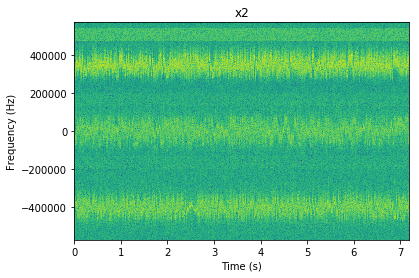

In [73]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )

If you view this spectogram, you should see the FM signal now centered at baseband.

Our next step will be to filter and then downsample the signal to focus only the FM radio signal.

In [74]:
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000  
n_taps = 64

# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

# now resample
x4 = signal.upfirdn(lpf, x2, 1, 5)

# Calculate the new sampling rate
Fs_y = Fs/dec_rate

Now we are working with a narrower view of the spectrum, as seen in the spectogram of x4:

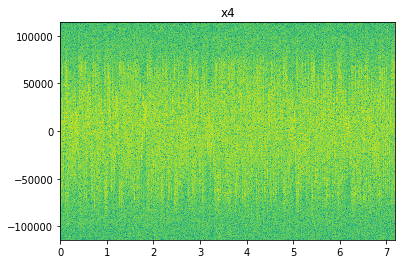

In [75]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  

We can also plot the constellation, which should have the circular pattern typical of an FM signal:

(-1.1, 1.1)

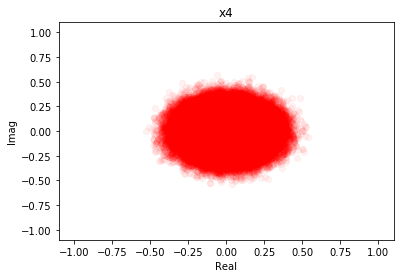

In [76]:
# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  

If your constellation looks like a filled circle rather than an outline, this suggests a noisy signal. You'll know for certain when you listen to the audio output!

Since we are left with just the 200kHz FM broadcast signal, we can now demodulate it with our polar discriminator:

In [77]:
### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)

and we can visualize the signal with:

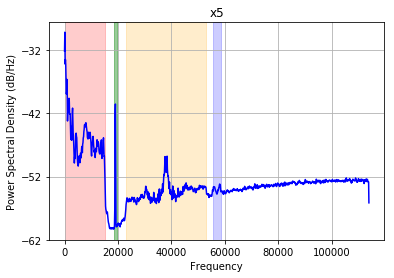

In [78]:
# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )

Compare this to the figure above showing the parts of the FM broadcast signal. Broadcasts vary with respect to which parts of the signal they include.

Now we're ready for the de-emphasis filter:

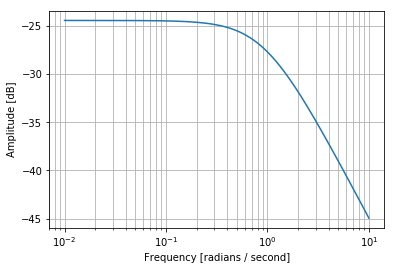

In [79]:
# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)

w, h = signal.freqs(b, a, 1000)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(w, 20 * np.log10(abs(h)))
ax.set_xscale('log')
ax.set_xlabel('Frequency [radians / second]')
ax.set_ylabel('Amplitude [dB]')
#ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

And then we can decimate once again to focus on the mono audio part of the broadcast:

In [80]:
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

and finally, we can write to an audio file:

In [81]:
# Scale audio to adjust volume
x7 *= 10000 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
x7.astype("int16").tofile("../vectors/ota_fm_radio_python_mono.raw")

Find out what your audio sampling rate by checking the value of

In [82]:
print(Fs_audio)  

45600.0
